# Случайные процессы. Прикладной поток.
## Практическое задание 1

**Правила:**

* Выполненную работу нужно отправить на почту `probability.diht@yandex.ru`, указав тему письма `"[СП17] Фамилия Имя - Задание 1"`. Квадратные скобки обязательны. Вместо `Фамилия Имя` нужно подставить свои фамилию и имя.
* Прислать нужно ноутбук и его pdf-версию. Названия файлов должны быть такими: `1.N.ipynb` и `1.N.pdf`, где `N` - ваш номер из таблицы с оценками.
* Никакой код из данного задания при проверке запускаться не будет.
* Дедлайн и система оценивания будут объявлены позже.

<IMG SRC="https://www.wikitree.com/images/wikitree-logo.png">


В Британской империи в Викторианскую эпоху (1837—1901) было обращено внимание на вымирание аристократических фамилий. В связи с этим в своей статье в The Educational Times в 1873 году Гальтон поставил вопрос о вероятности вымирания фамилии. Решение этого вопроса нашел Ватсон и вместе в 1874 году они написали статью "On the probability of the extinction of families".
На сайте <a href="http://wikitree.com">wikitree.com</a> в свободно распространяемом формате собрано большое количество данных о родословных различных людей. В коллекции есть как люди, жившие во времена поздней античности, так и наши современники. На основе некоторой части этих данных вам предстоит провести исследование о вымирании фамилий.

Вам предоставляются несколько файлов, в которых содержатся данные о некоторых родословных. Вам предстоит проводить исследование на нескольких из этих файлов (каких именно, см. в таблице). Формат файлов следующий:

`generation \t name \t gender \t birthday \t deathdate \t parents \t siblings \t spouses \t children`

Эти данные означают номер поколения, фамилию, пол, дату рождения, дату смерти, родителей, братьев и сестер, супруг, детей соответственно. Если какая-то характеристика неизвестна (кроме номера поколения и фамилии), вместо нее ставится пустая подстрока. Если каких-то характеристик несколько, то они разделены через ";". Все люди представлены некоторым идентификатором `<id>`, который соответствует адресу `http://www.wikitree.com/wiki/<id>`. Например, идентификатор `Romanov-29` соответствует адресу <a href="http://www.wikitree.com/wiki/Romanov-29">`http://www.wikitree.com/wiki/Romanov-29`</a>. В файле родословные отделяются друг от друга пустой строкой.

Для облегчения вашей работы мы предоставляем вам код, который считывает данные из этого файла и преобразует их в список ветвящихся процессов. Каждый ветвящийся процесс содержит список списков, в каждом из которых содержатся все люди из соответствующего поколения. Обратите внимание, что одни и те же родословные могут попасть в разные файлы. В таком случае их можно считать разными, но при желании вы можете удалить копии.

В предоставленных данных в каждой родословной для каждого мужчины на следующем поколении содержатся все его дети, которые были указаны на сайте. Для женщин дети в данной родословной не указаны. Это связано с тем, что женщины обычно меняют свою фамилию, когда выходят замуж, тем самым, они переходят в другую ветку. С точки зрения ветвящихся процессов, нужно иметь в виду, что если у мужчины родилось 3 мальчика и 4 девочки, то у него 3 потомка как продолжателя фамилии.

Ваша задача --- исследовать процесс вымирания фамилий на основе предложенных данных. В данном задании вам предстоит сделать оценку закона размножения, а в следующем задании --- провести остальной анализ.

In [1]:
import numpy as np
import scipy.stats as sps
from collections import Counter  # это может пригодиться
from BranchingProcess import Person, BranchingProcess, read_from_files

from scipy.special import factorial

import matplotlib.pyplot as plt
from matplotlib import rcParams
rcParams.update({'font.size': 16})
%matplotlib inline

## 1. Описательный анализ

Большая часть кода, необходимая для проведения данного анализа, является технической и основывается на работе с пакетом `BranchingProcess`. Поэтому данный код полностью вам выдается, вам нужно только выполнить его, подставить имена файлов. Кроме того, код анализа позволит вам лучше понять структуру данных.

Считайте данные с помощью предложенного кода. Посчитайте количество родословных.

In [138]:
processes = read_from_files(['data/L.txt','data/R.txt', 'data/J.txt','data/P.txt', 'data/D.txt',
                             'data/F.txt', 'data/E.txt', 'data/O.txt', 'data/M.txt', 'data/W.txt'])
print(len(processes))

62034


В имеющихся данных очень много людей, про которых известно лишь то, что они когда-то существовали. Обычно их фамилия неизвестна (вместо фамилии у них может стоять, к примеру, `B-290`), а у некоторых из них неизвестен даже пол, не говоря уже о родителях и детях. Такие данные стоит удалить.

Удалите все процессы, состоящие только из одного поколения (в котором, естественно, будет только один человек).
Сколько осталось процессов?

In [139]:
for i in range(len(processes))[::-1]:
    if len(processes[i].generations) < 2:
        del processes[i]

print(len(processes))

17898


**Удаляем странные фамилии (фамилии, которые состоят только из одной буквы, то есть имеют вид B-29)**

In [4]:

for i in range(len(processes))[::-1]:
    for j in range(len(processes[i].generations)):
        for person in processes[i].generations[j]:
            if(person.name[1] == '-'):
                del person
print(len(processes))

17898


Для лучшего понимания задачи и предложенных данных посчитайте следующие характеристики: минимальное, максимальное и среднее число поколений в роду, год рождения самого старого и самого молодого человека, среднюю продолжительность жизни.

In [5]:
generation_counts = []
years = []

for pedigree in processes:
    generation_counts.append(len(pedigree.generations))
    
    for generation in pedigree.generations:
        for person in generation:
            if person.birthday != '':
                years.append(person.birthday.split('-')[0])

years = np.array(years, dtype=int)
print('Минимальное число поколений в роду:', min(generation_counts))
print('Максимальное число поколений в роду:', max(generation_counts))
print('Среднее число поколений в роду:', round(np.mean(generation_counts), 1))
print('Год рождения самого старого:', min(years))
print('Год рождения самого молодого:', max(years))

Минимальное число поколений в роду: 2
Максимальное число поколений в роду: 66
Среднее число поколений в роду: 3.3
Год рождения самого старого: 1
Год рождения самого молодого: 2000


Постройте гистограмму зависимости количества поколений в родословной от количества родословных.
На следующем графике отложите на временной оси года рождения всех людей.

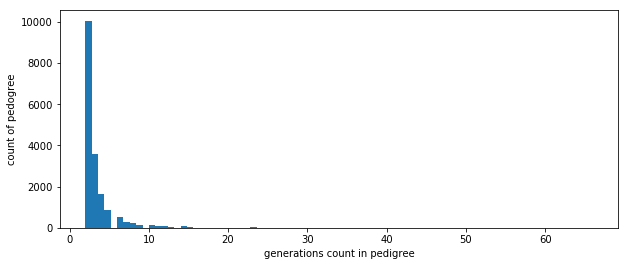

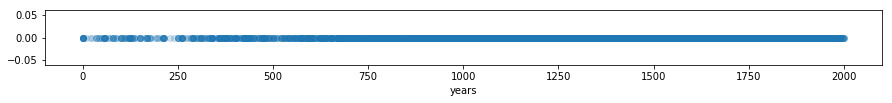

In [6]:
plt.figure(figsize=(10, 4))
plt.hist(generation_counts, bins=80)
plt.xlabel('generations count in pedigree')
plt.ylabel('count of pedogree')
plt.show()

plt.figure(figsize=(15, 1))
plt.scatter(years, np.zeros_like(years), alpha=0.2)
plt.xlabel('years')
plt.show()

Посчитайте среднюю продолжительность жизни.

In [7]:
ages = []
for pedigree in processes:
    for generation in pedigree.generations:
        for person in generation:
            if person.birthday != '' and person.deathdate != '':
                ages.append(int(person.deathdate.split('-')[0]) - \
                            int(person.birthday.split('-')[0]))

mean_age = np.mean(ages)
print(round(mean_age, 2))

57.17


## 2. Оценка закона размножения

Для начала предположим, что все выданные вам процессы являются частью одного большого процесса с общим предком. В следующем задании рассмотрим так же случай, когда все процессы являются разными.

Чтобы проводить какой-либо анализ ветвящегося процесса нужно некоторым образом оценить закон размножения. Кажется,  что для этого достаточно посчитать количество сыновей у каждого человека, получив тем самым выборку неотрицательных целых чисел. Однако, проблема в том, что данные неполные, в частности, некоторые поля могут быть не заполнены. Тем не менее обычно у человека указаны либо все дети, либо не указаны вообще. 
Таким образом, условно мы можем разделить выборку на две части: поле детей заполнено (в т.ч. если у человека на самом деле нет детей), поле детей незаполнено. Если бы первая часть выборки была бы полностью известна, что распределение можно оценить по ней. Нам же неизвестен размер выборки и количество нулевых элементов в ней. Количество положительных элементов известно.


**Математическая постановка задачи**

$\mathsf{P}_\theta$ --- неизвестное распределение из некоторого класса распределений $\mathcal{P}$ на $\mathbb{Z}_+$.

$X_1, ..., X_n$ --- выборка из распределения $\mathsf{P}_\theta$, причем $n$ и количество нулей в выборке неизвестны. 

$Y_1, ..., Y_s$ --- положительная подвыборка, которая полностью нам известна. В нашей задаче $Y_j$ --- количество сыновей у $j$-го человека среди тех, у кого есть хотя бы один сын.

Оценку параметра $\theta$ можно найти методом максимального правдоподобия:

$$\prod_{i=1}^s \mathsf{P}_\theta (Y_i \left| Y_i > 0 \right) \to \max_\theta$$ 

В качестве классов распределений $\mathcal{P}$ рассмотрите пуассоновское и геометрическое распределения. По желанию можете рассмотреть другие классы распределений, осмысленные в данной задаче

**Внимание!** Применение метода `fit` из `scipy.stats` является некорректным в данной задаче, поскольку рассматривается усеченная выборка. Задачу максимизации нужно решить явно, выписав все формулы (которые тоже нужно прислать вместе с кодом).

После оценки параметров проведите проверку принадлежности неизвестного распределения рассматриваемому семейству распределений $\mathcal{P}$ с помощью критерия хи-квадрат, взяв для для него то распределение из $\mathcal{P}$, которое соответствует оценке максимального правдоподобия. Постарайтесь учесть все особенности проверки гипотез, которые обсуждались на семинаре. Для каждого класса постройте также график частот и функции $\mathsf{P}_\theta (y \left| Y > 0 \right).$

**Сделаем выборку(считаем количество сыновей для каждого человека)**

In [187]:
sample_sons = []
for i in range(len(processes)):
    for j in range(len(processes[i].generations) - 1):
        for person in processes[i].generations[j]:
            if person.gender == 'male':
                count_sons = 0
                for child in person.children:
                    k = 0
                    person_next_generation = processes[i].generations[j+1][k]
                    while k < len(processes[i].generations[j+1]) and person_next_generation.name != child:
                        person_next_generation = processes[i].generations[j+1][k]
                        k +=1
                    if(k < len(processes[i].generations[j+1]) and person_next_generation.gender == 'male'):
                        count_sons += 1
                if count_sons > 0:
                    sample_sons.append(count_sons)

sample_big = np.array(sample_sons)


Сначала поймем, что такое $\mathsf{P}_\theta (Y_i \left| Y_i > 0 \right)$ :
$$\mathsf{P}_\theta (Y_i \left| Y_i > 0 \right) = \frac{P_\theta(Y_i \cap (Y_i>0))}{P_\theta(Y_i > 0)}$$
Так как все элементы нашей выборки строго положительны, то:
$$\mathsf{P}_\theta (Y_i \left| Y_i > 0 \right) = \frac{P_\theta(Y_i)}{P_\theta(Y_i > 0)}$$

**Теперь уменьшим размер выборки**

In [188]:
import random

samples = []
sample_little = []
count_samples = 10
n = 60
for i in range(count_samples):
    for j in range(n):
        sample_little.append(random.choice(sample_big))
    samples.append(sample_little)
    sample_little = []
samples = np.array(samples)


**Для пуассоновского распределения с параметром $\theta$ ( $\theta \in (0, \infty)$ ) :** <br>
$$p(x) = \frac{e^{-\theta} \theta^x}{x!}$$
$$F_{\theta}(Y_1, ..., Y_s) = \frac{e^{-s\theta} \theta^{Y_1 + ... + Y_s}}{Y_1! ... Y_s!} \frac{1}{(1 - e^{-\theta})^s}$$
$$L_{\theta}(Y_1, ..., Y_s) = -s\theta + \sum_{i=1}^s{Y_i}  ln(\theta) - \sum_{i=1}^s{ln(Y_i!)} + s\theta - sln(e^{\theta} - 1)$$
$$L'_{\theta}(Y_1, ..., Y_s) = \frac{\sum_{i=1}^s{Y_i}}{\theta} - s \frac{e^\theta}{e^{\theta} - 1} = 0$$ <br>
$$\Rightarrow \overline{Y} = \theta \frac{e^{\theta}}{e^{\theta} - 1}$$
Функция $\theta \frac{e^{\theta}}{e^{\theta} - 1}$ является монотонно возрастающей, поэтому для нахождения $\theta$ применим бинпоиск.

In [189]:
evaluate = lambda x, overline_Y: (x * (np.exp(x)) / (np.exp(x) - 1)) - overline_Y

#Нахождение решения бинпоиском
def bin_search(left, right, eps, overline_Y):
    middle = (left + right) / 2
    if(np.abs(evaluate(middle, overline_Y)) < eps):
        return middle
    if(evaluate(middle, overline_Y) > 0): 
        right = middle
    elif(evaluate(middle, overline_Y) < 0):
        left = middle
    return bin_search(left, right, eps, overline_Y)



def find_theta_pois(sample):
    overline_Y = np.mean(sample)
    return bin_search(0.05, 10, 0.00001, overline_Y)



**Для геометрического распредления с параметром $\theta$ $(\theta \in$ (0, 1])** :

$$p(x) = (1 - \theta)^{x} \theta$$
$$F_{\theta}(Y_1, ..., Y_s) = \prod_{i=1}^s \mathsf{P}_\theta (Y_i \left| Y_i > 0 \right) = \frac{(1 - \theta)^{{\sum {Y_i}}} \theta^s}{(1 - \theta)^s} =  (1 - \theta)^{{\sum {Y_i}} - s} \theta^s$$
$$L_{\theta}(Y_1, ..., Y_s) = {\sum_{i = 1}^s {Y_i} - s} ln(1 - \theta) + {s}ln(\theta)$$
$$L'_{\theta}(Y_1, ..., Y_s) = -\frac{\sum_{i = 1}^s {Y_i} - s}{1 - \theta} + \frac{s}{\theta}  = 0$$ <br>
$$\Rightarrow \theta^* = \frac{1}{\overline{Y}}$$


In [190]:
def find_theta_geom(sample):
    overline_Y = np.mean(sample)
    return 1 / overline_Y


**Сначала, для наглядности, нарисуем графики**

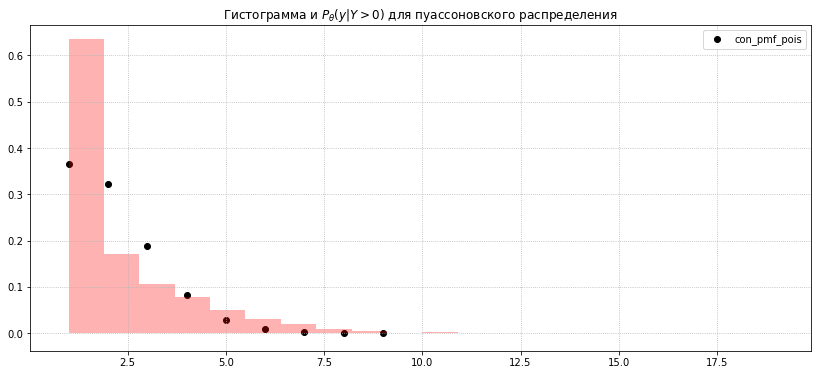

theta для пуассоновского: 1.7619401931762693


In [191]:
grid = np.arange(1, 10, 1)
theta_for_pois = find_theta_pois(sample_big)
theta_for_geom = find_theta_geom(sample_big)

con_pdf_pois = (((theta_for_pois**grid) / factorial(grid)) * np.exp(-theta_for_pois)) / (1 - np.exp(-theta_for_pois))
con_pdf_geom = ((1 - theta_for_geom)**(grid - 1)) * theta_for_geom

plt.figure(figsize=(14, 6))
plt.title("Гистограмма и $P_\\theta (y | Y > 0)$ для пуассоновского распределения")
plt.hist(sample_big, normed=True, bins=20, color = 'red', alpha = 0.3)
plt.scatter(grid, con_pdf_pois, color='black', label='con_pmf_pois', alpha = 1)
plt.grid(ls=':')
plt.legend()
plt.show()

print("theta для пуассоновского:", theta_for_pois)

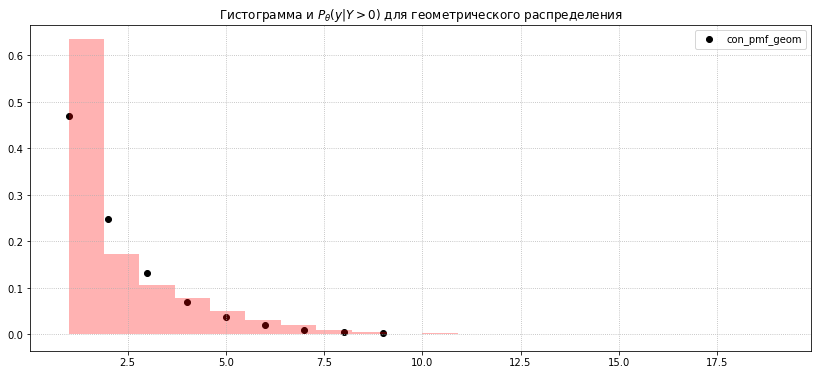

theta для геометрического: 0.470101169954


In [192]:
plt.figure(figsize=(14, 6))
plt.title("Гистограмма и $P_\\theta (y | Y > 0)$ для геометрического распределения")
plt.hist(sample_big, normed=True, bins=20, color = 'red', alpha = 0.3)
plt.scatter(grid, con_pdf_geom, color='black', label='con_pmf_geom', alpha = 1)
plt.grid(ls=':')
plt.legend()
plt.show()
print("theta для геометрического:", theta_for_geom)

**Из графиков видно, что неизвестное распределение больше похоже на геометрическое распределение с параметром $\theta = 0.469$**

Теперь найдем статистику и pvalue

In [193]:
#Функция, выполняющая разбиение
#    первый аргумент - разбиваемая подвыборка, второй - номер этой подвыборки
#    третий, четвертый - массивы для записи кол-ва элементов в интервалах разбиения
#    пятый, шестой - массивы для записи мат.ожиданий попадания в интервалы
def split(sample, i, counts_pois, counts_geom, E_pois, E_geom):
    

    #Разобьем нашу выборку по значениям (рассматриваем кол-во людей имеющих одинаковое кол-во сыновей)
    counts_dict = dict()
    for value in sample:
        if(value in counts_dict.keys()):
            counts_dict[value] += 1
        else:
            counts_dict[value] = 1

    #Матожидания попадания в интервал (то есть матожидание кол-во людей с определенным кол-вом сыновей)
    E_pois_dict = dict()
    E_geom_dict = dict()
    for value in counts_dict.keys():
        #считаем вероятности конкретного значения x для двух распределений
        E_pois_dict[value] = sps.poisson(theta_pois[i]).pmf(value) * len(sample)
        E_geom_dict[value] = sps.geom(theta_geom[i]).pmf(value) * len(sample)


    #Преобразуем данные в массивы
    for value in counts_dict.keys():
        counts_pois.append(counts_dict[value])
        counts_geom.append(counts_dict[value])
        E_pois.append(E_pois_dict[value])
        E_geom.append(E_geom_dict[value])
    
    

#функция,объединяющая некоторые интервалы для того,чтобы для каждого интервала матожидание попадания в него было >=5
def union(E, counts):
    while min(E) < 5:
        id_min1 = E.index(min(E))
        E_min1 = E[id_min1]
        count1 = counts[id_min1]
        E.pop(id_min1)
        counts.pop(id_min1)
        id_min2 = E.index(min(E))
        E[id_min2] += E_min1
        counts[id_min2] += count1


def chisquare_format(result, alpha=0.05):
    print("Статистика критерия хи-квадрат:", round(result.statistic, 3))
    print("p-value: ", round(result.pvalue, 3))
    if result.pvalue < alpha:
        print("Гипотеза отвергается.")
    else:
        print("Гипотеза не отвергается.")
        


**Теперь применим критерий хи-квадрат для проверки гипотезы для каждой подвыборки**

In [194]:
#массив получившихся p_value для каждой подвыборки
p_values_pois = []
p_values_geom = []

#массивы найденных theta для разных подвыборок
theta_pois = []
theta_geom = []
for i in range(count_samples):
    theta_pois.append(find_theta_pois(samples[i]))
    theta_geom.append(find_theta_geom(samples[i]))

    
#массивы для записи текущих результатов для каждой подвыборки, а именно кол-во элементов в интервале
#  и мат.ожидание попадания в интервал.
counts_pois = []
counts_geom = []
E_pois = []
E_geom = []

#Для каждой подвыборки считаем pvalue
for i in range(count_samples):
    split(samples[i], i, counts_pois, counts_geom, E_pois, E_geom)
    union(E_pois, counts_pois)
    union(E_geom, counts_geom)

    #Находим статистику и pvalue
    test_pois = sps.chisquare(counts_pois, E_pois)
    test_geom = sps.chisquare(counts_geom, E_geom)
    p_values_pois.append(test_pois.pvalue)
    p_values_geom.append(test_geom.pvalue)
    E_pois = []
    E_geom = []
    counts_pois = []
    counts_geom = []

In [195]:
#Множественная проверка гипотез
from statsmodels.sandbox.stats.multicomp import multipletests

result_pois = multipletests(p_values_pois, method='bonferroni', is_sorted=False)
result_geom = multipletests(p_values_geom, method='bonferroni', is_sorted=False)

print("Гипотеза: Распределение Пуассоновское")
print("Отвергаем:", result_pois[0])
print(result_pois[1])
print("\nГипотеза: Распределение геометрическое")
print("Отвергаем:", result_geom[0])
print(result_geom[1])

Гипотеза: Распределение Пуассоновское
Отвергаем: [ True  True  True  True False  True  True  True  True  True]
[  1.96504138e-03   1.30711840e-04   1.46502638e-02   9.26535903e-04
   1.65457766e-01   2.59433008e-04   1.75876056e-03   2.11243961e-03
   2.02269143e-06   1.59843534e-02]

Гипотеза: Распределение геометрическое
Отвергаем: [False False False False False False False False False False]
[ 1.          0.85843981  1.          1.          1.          0.28854837
  1.          1.          0.13655354  1.        ]


**Вывод: Проведя несколько тестов для 10ти выборок, используя критерий хи-квадрат и мнежественную проверку гипотез, понимаем, что нужно отвергнуть гипотезу о том, что распределение Пуассоновское. Гипотезу о том, что распределение геометрическое принимаем (шутка, не отвергаем !).**